<font size = "5">**Author: Rishav Bhattacharjee**
    
<font size = "5">**Date: May, 2024**
    
<font size = "3">Work inspired from: https://github.com/abhmalik/halo_conc-regression-ML/blob/master/Regression_Halos.ipynb

<font size="5">**Regression Analysis on Dark Matter Halo Dataset from Bolshoi Simulation**

<font size="3">In this notebook, we will carry out a simple regression task.


<font size="3">First, we will download a public dark matter halo catalogue from the catalogue. 
Link: https://www.slac.stanford.edu/~behroozi/Bolshoi_Catalogs/

<font size="3">We will then use the Pandas library to analyse this halo catalogue and to identify correlation between different halo properties. In the next step, we will use the Scikit-Learn library to predict the halo concentration from the other halo properties. For this, we will test simple AdaBoost, XGBoost, and Catboost Machine Learning models. Then at the end, we will determine which regression algorithm performs best with respect to the test data set.


* <font size="3">**Importing necessary Libraries and module**

In [36]:
#Import modules
#Here we import all modules/libraries that are needed later. Don't worry for now.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#Plot in cells
%matplotlib inline

* <font size="3">**Loading the dataset using pandas**</font>

In [37]:
import pandas as pd
#data = pd.read_csv("/kaggle/input/dark-matter-2/hlist_0.13835.list.list", comment ="#", skiprows=1000, delim_whitespace=True)

data = np.genfromtxt("/kaggle/input/dark-matter-2/hlist_0.13835.list.list",comments='#',skip_header=1000, max_rows=10000)
#data = np.genfromtxt("/kaggle/input/dark-matter-3/hlist_0.16235.list..list",comments='#',skip_header=1000, max_rows=10000)


#data = data[(data != 0).all(axis=1)]

len(data)


10000

In [38]:
data

array([[1.3835000e-01, 4.5574366e+07, 1.4435000e-01, ..., 2.9990000e+09,
        5.7590000e+01, 5.7590000e+01],
       [1.3835000e-01, 4.5574367e+07, 1.4435000e-01, ..., 1.8400000e+09,
        4.6220000e+01, 5.1330000e+01],
       [1.3835000e-01, 4.5574368e+07, 1.4435000e-01, ..., 9.5380000e+08,
        3.5050000e+01, 3.5050000e+01],
       ...,
       [1.3835000e-01, 4.5431158e+07, 1.4435000e-01, ..., 1.0900000e+09,
        3.5760000e+01, 3.5760000e+01],
       [1.3835000e-01, 4.5431159e+07, 1.4435000e-01, ..., 3.5440000e+09,
        5.6440000e+01, 5.6390000e+01],
       [1.3835000e-01, 4.5431161e+07, 1.4435000e-01, ..., 1.7450000e+10,
        9.2540000e+01, 1.0753000e+02]])

In [39]:
#Define halo properties
#Each column gives us a different halo property. Here we define all those properties we want to use.

virial_mass   = np.log10(data[:,10])
virial_radius = np.log10(data[:,11])
concentration = np.log10(data[:,11] / data[:,12]) #Concentration is virial radius divided by scale length
velocity_disp = np.log10(data[:,13])
vmax          = np.log10(data[:,16])
spin          = np.log10(data[:,26])
b_to_a        = data[:,44]
c_to_a        = data[:,45]
energy_ratio  = data[:,54]
peak_mass     = np.log10(data[:,58])
peak_vmax     = np.log10(data[:,60])
halfmass_a    = data[:,61]
peakmass_a    = data[:,67]
acc_rate      = data[:,64]

#Create Pandas Data Frame
#For easier handling we use the Pandas library.
#The following lines load all halo properties into a Pandas data frame called halos.
#Add all halo properties here, after virial_mass:
halos = pd.DataFrame({
    'Virial Mass':virial_mass,
    'Virial Radius':virial_radius,
    'Concentration':concentration,
    'Velocity Disp':velocity_disp,
    'Vmax':vmax,
    'Spin':spin,
    'B to A':b_to_a,
    'C to A':c_to_a,
    'Energy ratio':energy_ratio,
    'Peak Mass':peak_mass,
    'peak Vmax':peak_vmax,
    'Halfmass a':halfmass_a,
    'Peakmass a':peakmass_a,
    'Acc Rate':acc_rate
})

/tmp/ipykernel_35/2812767304.py:7: RuntimeWarning: divide by zero encountered in log10
  velocity_disp = np.log10(data[:,13])
/tmp/ipykernel_35/2812767304.py:9: RuntimeWarning: divide by zero encountered in log10
  spin          = np.log10(data[:,26])


In [40]:
#print(halos.head())
halos

,Virial Mass,Virial Radius,Concentration,Velocity Disp,Vmax,Spin,B to A,C to A,Energy ratio,Peak Mass,peak Vmax,Halfmass a,Peakmass a,Acc Rate
0,9.476976,1.576307,0.918486,1.649919,1.760347,-1.738737,0.625970,0.247110,0.475600,9.476976,1.760347,0.1323,0.1384,9.232
1,9.264818,1.505638,0.771479,1.516668,1.664830,-1.513711,0.489495,0.090530,0.469400,9.389698,1.710371,0.1323,0.1323,-10.360
2,8.979457,1.410524,0.576803,1.426023,1.544688,-1.277366,0.490247,0.172643,0.746667,8.979457,1.544688,0.1203,0.1384,1.639
3,9.596927,1.616297,0.832393,1.679610,1.783904,-1.703993,0.709400,0.455890,0.462800,9.596927,1.825426,0.1084,0.1384,7.548
4,10.424555,1.892178,0.457466,2.053885,2.028368,-1.826522,0.571490,0.369150,0.714800,10.424555,2.028368,0.1203,0.1384,96.650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,10.747256,1.999761,0.784309,2.197887,2.155154,-1.580209,0.652450,0.608320,0.703800,10.747256,2.161937,0.1203,0.1384,164.900
9996,9.088845,1.446910,0.704342,1.622628,1.594061,-1.733533,0.578400,0.156790,1.016000,9.496238,1.818160,0.1023,0.1023,-12.100
9997,9.037426,1.429865,0.459658,1.466126,1.553398,-1.617263,0.648910,0.242000,0.966600,9.037426,1.553398,0.1323,0.1384,9.212
9998,9.549494,1.600494,0.731438,1.773128,1.751587,-1.961777,0.898910,0.688130,0.813400,9.549494,1.751587,0.1084,0.1323,4.975


<font size = "3">This is just to check the distribution of the datas per column

In [43]:
stats = pd.DataFrame({
    'Max': halos.max(),
    'Min': halos.min(),
    'Mean': halos.mean(),
    'Std_Dev': halos.std()
})

print(stats)

                       Max         Min       Mean    Std_Dev
Virial Mass      11.623146    8.435526   9.464288   0.469917
Virial Radius     2.291731    1.229170   1.572099   0.156641
Concentration     1.606386    0.001470   0.686727   0.219415
Velocity Disp     2.493388        -inf       -inf        NaN
Vmax              2.440059    1.350442   1.725462   0.160348
Spin              0.020813        -inf       -inf        NaN
B to A            0.999040    0.000000   0.520010   0.250425
C to A            0.901140    0.000000   0.258974   0.211776
Energy ratio     22.176800    0.000000   0.733001   0.638258
Peak Mass        11.623146    8.435526   9.487691   0.462045
peak Vmax         2.440059    1.350442   1.741682   0.160240
Halfmass a        0.138400    0.078400   0.122317   0.011691
Peakmass a        0.138400    0.096350   0.135876   0.006205
Acc Rate       1563.000000 -249.100000  17.953275  52.364690


/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [45]:
halos['Velocity Disp']

0       1.649919
1       1.516668
2       1.426023
3       1.679610
4       2.053885
          ...   
9995    2.197887
9996    1.622628
9997    1.466126
9998    1.773128
9999    1.997779
Name: Velocity Disp, Length: 10000, dtype: float64

In [46]:
halos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Virial Mass    10000 non-null  float64
 1   Virial Radius  10000 non-null  float64
 2   Concentration  10000 non-null  float64
 3   Velocity Disp  10000 non-null  float64
 4   Vmax           10000 non-null  float64
 5   Spin           10000 non-null  float64
 6   B to A         10000 non-null  float64
 7   C to A         10000 non-null  float64
 8   Energy ratio   10000 non-null  float64
 9   Peak Mass      10000 non-null  float64
 10  peak Vmax      10000 non-null  float64
 11  Halfmass a     10000 non-null  float64
 12  Peakmass a     10000 non-null  float64
 13  Acc Rate       10000 non-null  float64
dtypes: float64(14)
memory usage: 1.1 MB


In [47]:
arr=halos.to_numpy()
len(arr)

10000

<font size="3">**Plotting Histogram to analyse which attributes have a clear peak**</font>

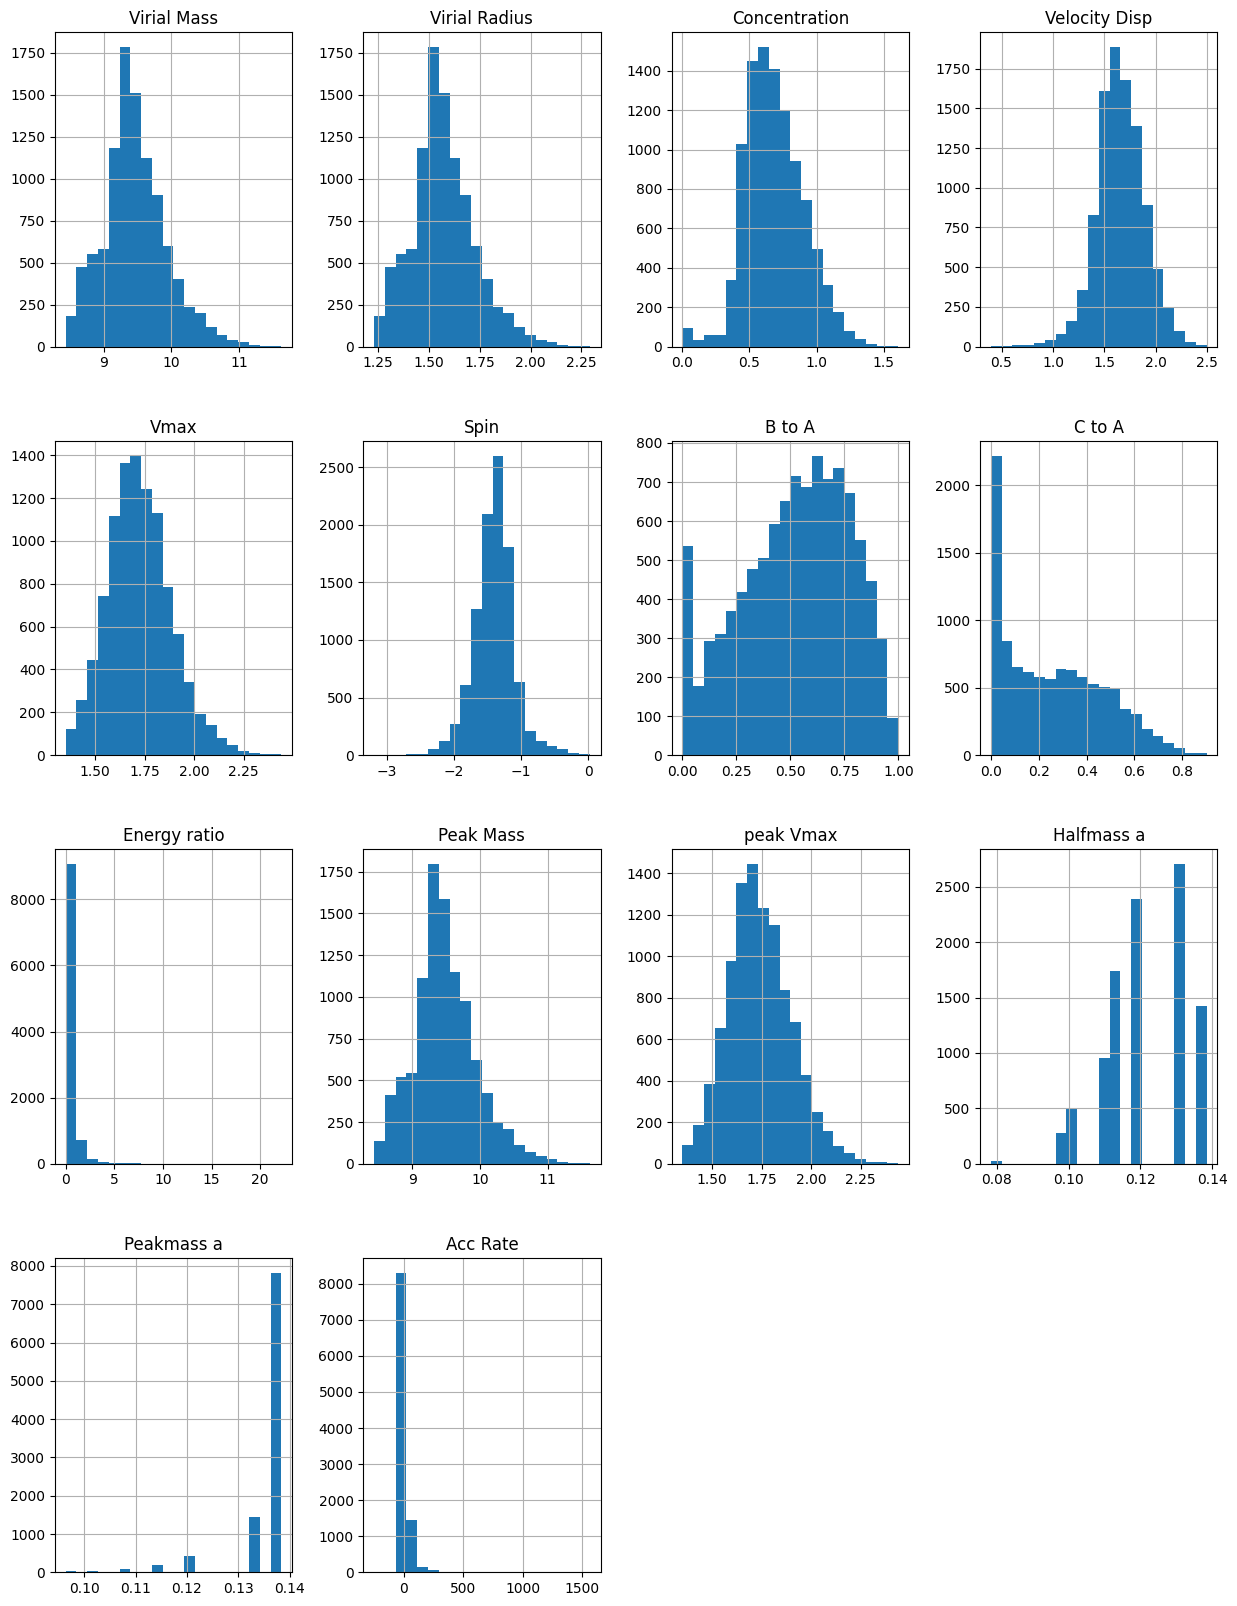

In [48]:
halos.replace([np.inf, -np.inf], np.nan, inplace=True)
#halos.dropna(inplace=True)

histograms = halos.hist(bins=20,figsize=[15,20])

<font size = "4">The histogram plots shows that some features exhibit uneven distributions. For instance, features like C to A start with the highest values and lack a distinct peak. In contrast, other features like spin, vmax, etc. display well-defined peaks. Therefore, feature scaling is necessary.

In [49]:
len(halos)

10000

## **DATA PREPROCESSING**

<font size="4">**Splitting dataset into training and test set**

<font size="3">Before applying feature scaling, it is essential to divide the dataset into training and test sets. This step is crucial for later evaluating the efficiency of our model and ensuring it performs well on unseen data.

In [50]:
#Split train and test set randomly
#We use 20 per cent of the total data set as test set
#Use train_test_split to split the data
#Use random_state= with some integer to always have the same random numbers
train, test = train_test_split(halos,test_size=0.2,random_state=23)

len(train)

8000

In [51]:
#Stratified split according to virial mass
#To be unbiased by the distribution of feature values, we can use stratified sampling.
#For this the split is not performed randomly, but sampled from subgroups (=strata) of a feature.
#Here we use the virial mass as a strata, and first define for each object, in which mass band it falls
cat_per_dex = 2.0 #This is the number of mass bands per dex of halo mass
mass_band = np.floor((virial_mass - virial_mass.min())*cat_per_dex)

len(mass_band)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=23)
for train_index, test_index in split.split(halos, mass_band):
    strat_train_set = halos.loc[train_index]
    strat_test_set = halos.loc[test_index]

In [52]:
#Copy stratified training set to halos data frame
#Copy the training set to the halos data frame using the .copy() function
halos = strat_train_set.copy()

<font size="4"> **CORRELATIONS IN THE DATA**

<font size="3">Now, let's examine the correlation between concentration and other features. This analysis will help us understand how concentration is related to other variables, providing insights on how these features can be used to predict concentration.

In [53]:
#Compute correlation matrix and show highest correlations for a given property
#The .corr() function gives us the correlation matrix
#You can then print the result with the ['Name of Feature'] subscript
#If you add .sort_values() the results will get sorted
corr_matrix = halos.corr()
print(corr_matrix['Concentration'].sort_values())

Acc Rate        -0.148613
Energy ratio    -0.138938
Virial Mass     -0.102022
Virial Radius   -0.102021
Peak Mass       -0.091028
Peakmass a      -0.077350
Spin            -0.020927
Velocity Disp   -0.006490
Halfmass a      -0.006096
peak Vmax        0.074445
Vmax             0.081765
B to A           0.193936
C to A           0.259588
Concentration    1.000000
Name: Concentration, dtype: float64


<font size="3"> **From above, we can see that 'Acc Rato' and 'Energy ratio ' has the highest anti-correlation whereas 'B to A' & 'C to A' has positive correlation with concentration.**

array([[<Axes: xlabel='Concentration', ylabel='Concentration'>,
        <Axes: xlabel='Halfmass a', ylabel='Concentration'>,
        <Axes: xlabel='Peakmass a', ylabel='Concentration'>,
        <Axes: xlabel='C to A', ylabel='Concentration'>,
        <Axes: xlabel='B to A', ylabel='Concentration'>],
       [<Axes: xlabel='Concentration', ylabel='Halfmass a'>,
        <Axes: xlabel='Halfmass a', ylabel='Halfmass a'>,
        <Axes: xlabel='Peakmass a', ylabel='Halfmass a'>,
        <Axes: xlabel='C to A', ylabel='Halfmass a'>,
        <Axes: xlabel='B to A', ylabel='Halfmass a'>],
       [<Axes: xlabel='Concentration', ylabel='Peakmass a'>,
        <Axes: xlabel='Halfmass a', ylabel='Peakmass a'>,
        <Axes: xlabel='Peakmass a', ylabel='Peakmass a'>,
        <Axes: xlabel='C to A', ylabel='Peakmass a'>,
        <Axes: xlabel='B to A', ylabel='Peakmass a'>],
       [<Axes: xlabel='Concentration', ylabel='C to A'>,
        <Axes: xlabel='Halfmass a', ylabel='C to A'>,
        <Axes: x

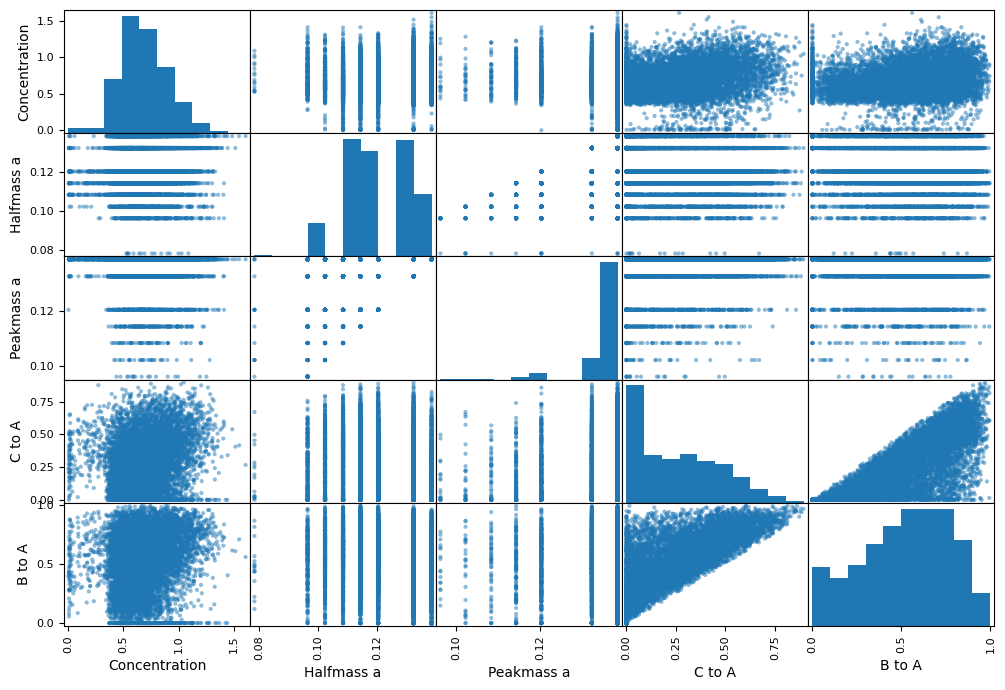

In [54]:
attributes=['Concentration','Halfmass a', 'Peakmass a', 'C to A', 'B to A']
pd.plotting.scatter_matrix(halos[attributes], figsize=(12,8))

<Axes: xlabel='C to A', ylabel='Concentration'>

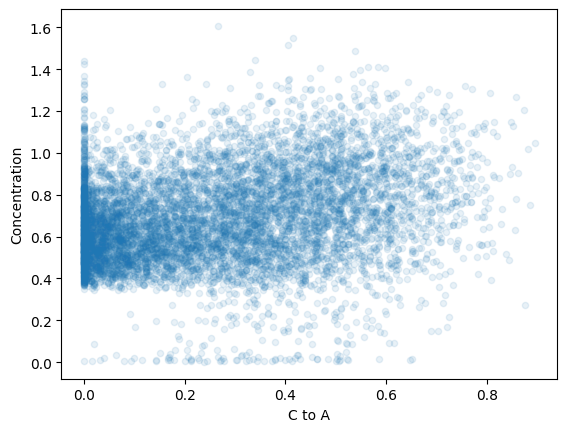

In [55]:
#Show scatter plot for highest correlation
halos.plot(kind='scatter', x='C to A', y='Concentration', alpha=0.1)

<font size="3">**Our primary goal is to identify the feature that has the highest correlation with concentration. Therefore, we are splitting the training set into two parts: one with concentration and one without concentration.**

In [56]:
#Select label for training and drop label from data set
halos_labels = strat_train_set['Concentration'].copy()
halos = strat_train_set.drop('Concentration', axis=1)

In [57]:
imputer = SimpleImputer(strategy='median')
halos_tr = pd.DataFrame(imputer.fit_transform(halos), columns=halos.columns)

In [58]:
#We cannot directly feed a Pandas data frame to scikit-learn.
#Therefore we need to difine a class that transforms our data fram into a numpy array.
#Define class to select a pandas data frame for sklearn input
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].values

<font size="3">**Based on the histograms, features with a clear peak should use a standard scaler (mean=0 & standard deviation=1). Features that decrease monotonically should use min-max scaling (min=0 & max=1). Some features are already scaled and do not need rescaling so we will assign them to other attributes.**

In [59]:
#Define attributes for min-maxing
minmax_attribs = ['Peakmass a','C to A', 'B to A', 'Energy ratio', 'Halfmass a']
#Define attributes for standard scaling
scaler_attribs = ['Virial Radius','Virial Mass','peak Vmax', 'Vmax', 'Spin', 'Velocity Disp']
#Set attributes that are left for no scaling
other_attribs  = list(halos)
for i in minmax_attribs: other_attribs.remove(i)
for i in scaler_attribs: other_attribs.remove(i)

In [60]:
# Define attributes for min-max scaling
minmax_attribs = ['Peakmass a', 'C to A', 'B to A', 'Energy ratio', 'Halfmass a']

# Define attributes for standard scaling
scaler_attribs = ['Virial Radius', 'Virial Mass', 'peak Vmax', 'Peak Mass', 'Vmax', 'Spin', 'Velocity Disp']

# Check for attributes in minmax_attribs that are not in halos
missing_minmax = [attrib for attrib in minmax_attribs if attrib not in halos]
if missing_minmax:
    print(f"Missing attributes in minmax_attribs: {missing_minmax}")

# Check for attributes in scaler_attribs that are not in halos
missing_scaler = [attrib for attrib in scaler_attribs if attrib not in halos]
if missing_scaler:
    print(f"Missing attributes in scaler_attribs: {missing_scaler}")

# If there are no missing attributes, proceed with removing them from other_attribs
if not missing_minmax and not missing_scaler:
    other_attribs  = list(halos)
    for i in minmax_attribs: 
        other_attribs.remove(i)
    for i in scaler_attribs: 
        other_attribs.remove(i)
else:
    print("Please correct the missing attributes in minmax_attribs or scaler_attribs.")


## **Creating the Pipeline**

In [61]:
# Pipeline for min-max scaling
minmax_pipeline = Pipeline([
    ('selector', DataFrameSelector(minmax_attribs)),
    ('imputer', SimpleImputer(strategy='median')),
    ('minmax', MinMaxScaler())
])

# Pipeline for standard scaling
scaler_pipeline = Pipeline([
    ('selector', DataFrameSelector(scaler_attribs)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('standard', StandardScaler())
])

# Pipeline for no scaling
other_pipeline = Pipeline([
    ('selector', DataFrameSelector(other_attribs)),
    ('imputer', SimpleImputer(strategy='median'))
])

# Combine Pipelines
full_pipeline = FeatureUnion(transformer_list=[
    ('minmax_pipeline', minmax_pipeline),
    ('scaler_pipeline', scaler_pipeline),
    ('other_pipeline', other_pipeline)
])

In [62]:
#Run halos through input pipeline to create scaled numpy array
halos_prepared = full_pipeline.fit_transform(halos)

In [63]:
full_pipeline

FeatureUnion(transformer_list=[('minmax_pipeline',
                                Pipeline(steps=[('selector',
                                                 DataFrameSelector(attribute_names=['Peakmass '
                                                                                    'a',
                                                                                    'C '
                                                                                    'to '
                                                                                    'A',
                                                                                    'B '
                                                                                    'to '
                                                                                    'A',
                                                                                    'Energy '
                                                                                    'ratio',
                                                                                    'Halfmass '
                                                                                    'a'])),
                                                ('imputer',
                                                 SimpleImputer(strategy='median')),
                                                ('minmax', MinMaxScaler())])),
                               ('scaler_pipeline',
                                Pipeline(steps=[('selector',
                                                 DataFrameSelector(attribute_names=['Virial '
                                                                                    'Radius',
                                                                                    'Virial '
                                                                                    'Mass',
                                                                                    'peak '
                                                                                    'Vmax',
                                                                                    'Peak '
                                                                                    'Mass',
                                                                                    'Vmax',
                                                                                    'Spin',
                                                                                    'Velocity '
                                                                                    'Disp'])),
                                                ('imputer', SimpleImputer()),
                                                ('standard',
                                                 StandardScaler())])),
                               ('other_pipeline',
                                Pipeline(steps=[('selector',
                                                 DataFrameSelector(attribute_names=['Acc '
                                                                                    'Rate'])),
                                                ('imputer',
                                                 SimpleImputer(strategy='median'))]))])

In [64]:
halos

,Virial Mass,Virial Radius,Velocity Disp,Vmax,Spin,B to A,C to A,Energy ratio,Peak Mass,peak Vmax,Halfmass a,Peakmass a,Acc Rate
3,9.596927,1.616297,1.679610,1.783904,-1.703993,0.70940,0.45589,0.4628,9.596927,1.825426,0.1084,0.1384,7.548
2427,10.195069,1.815730,1.988381,1.995284,-1.380072,0.70356,0.47575,0.6436,10.195069,2.023252,0.1143,0.1384,40.000
1275,10.316390,1.856112,2.204527,1.977906,-1.132002,0.59278,0.42608,1.9042,10.316390,1.998347,0.1023,0.1384,43.520
461,8.435526,1.229170,NaN,1.390228,-1.019769,0.00000,0.00000,0.0000,8.435526,1.390228,0.1384,0.1384,1.861
8760,8.912647,1.388226,1.626443,1.529430,-0.756416,0.48673,0.16949,1.3776,9.280578,1.702861,0.0784,0.1023,-3.282
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9228,9.767972,1.673325,1.824061,1.839227,-1.397940,0.61537,0.41746,0.6596,9.767972,1.874308,0.1143,0.1384,10.780
713,9.678518,1.643522,1.800854,1.866996,-1.373249,0.67025,0.42613,0.5732,9.678518,1.931915,0.1084,0.1384,7.765
2825,9.702689,1.651569,1.781612,1.821317,-1.442974,0.81337,0.72852,0.5784,9.702689,1.821317,0.1143,0.1384,12.470
8155,10.130012,1.794049,1.947189,1.942157,-1.587371,0.81601,0.67854,0.6300,10.130012,1.981275,0.1143,0.1384,33.880


In [65]:
print(halos_prepared)

[[ 1.00000000e+00  5.08913721e-01  7.12850195e-01 ... -1.01873496e+00
   9.56566801e-02  7.54800000e+00]
 [ 1.00000000e+00  5.31083600e-01  7.06981792e-01 ...  6.12798281e-02
   1.43561591e+00  4.00000000e+01]
 [ 1.00000000e+00  4.75636575e-01  5.95663009e-01 ...  8.88392054e-01
   2.37361637e+00  4.35200000e+01]
 ...
 [ 1.00000000e+00  8.13252810e-01  8.17325857e-01 ... -1.48447447e-01
   5.38310967e-01  1.24700000e+01]
 [ 1.00000000e+00  7.57459729e-01  8.19978697e-01 ... -6.29895375e-01
   1.25685689e+00  3.38800000e+01]
 [ 1.00000000e+00  3.48957926e-02  1.81448209e-01 ... -5.59406187e-01
   4.79117823e-01  2.07300000e+01]]


## **Training the Models**

<font size="4">**1. AdaBoost**

AdaBoost RMSE: 0.17870695060363775


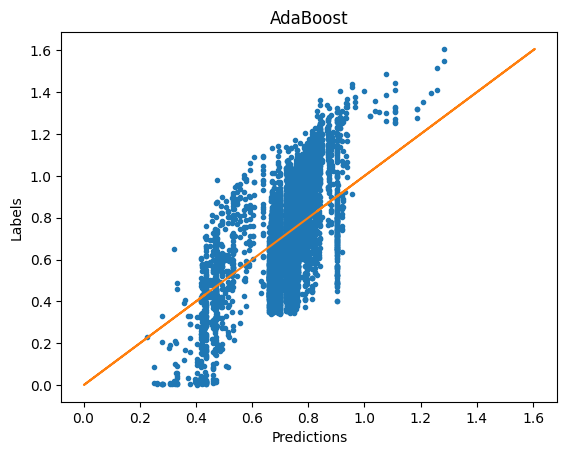

In [66]:
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# AdaBoost
ada_model = AdaBoostRegressor(random_state=35)
ada_model.fit(halos_prepared,halos_labels)
ada_predictions = ada_model.predict(halos_prepared)
ada_rmse = np.sqrt(mean_squared_error(halos_labels, ada_predictions))
print("AdaBoost RMSE:", ada_rmse)


#Plot prediction vs label
plt.plot(ada_predictions, halos_labels, '.');
plt.plot(halos_labels, halos_labels);
plt.title('AdaBoost')
plt.xlabel('Predictions');
plt.ylabel('Labels');


<font size="3">**From the above results we can see that Adaboost has underperformed heavily. We will try to improve it in next section where we will perform hyperparameter tunning.**

<font size="4">**2. XGBoost**

XGBoost RMSE: 0.023948570875477547


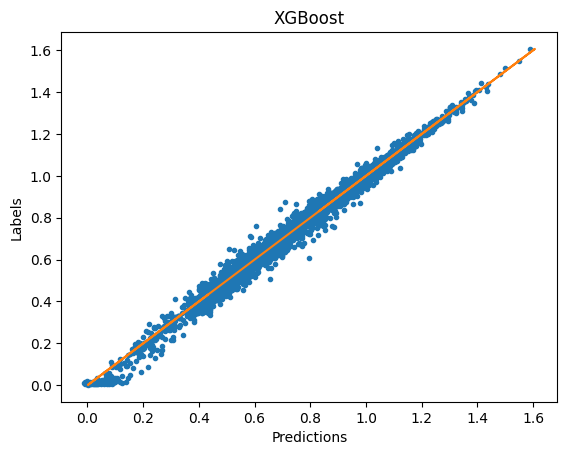

In [67]:
# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=23)
xgb_model.fit(halos_prepared,halos_labels)
xgb_predictions = xgb_model.predict(halos_prepared)
xgb_rmse = np.sqrt(mean_squared_error(halos_labels, xgb_predictions))
print("XGBoost RMSE:", xgb_rmse)

#Plot prediction vs label
plt.plot(xgb_predictions, halos_labels, '.');
plt.plot(halos_labels, halos_labels);
plt.title('XGBoost')
plt.xlabel('Predictions');
plt.ylabel('Labels');

<font size="4">**3. CatBoost**

CatBoost RMSE: 0.035492941046746204


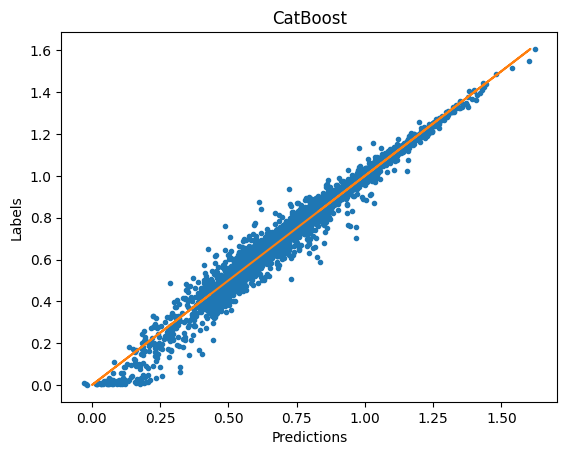

In [68]:
# CatBoost
cat_model = CatBoostRegressor(verbose=0,random_state=23)
#cat_model = CatBoostRegressor(  verbose=0,  depth=6,  # Decrease depth of trees
    #learning_rate=0.01,  # Adjust learning rate
    #iterations=10000,  # Reduce the number of iterations
    #l2_leaf_reg=3,  # Increase L2 regularization
   
   # random_state=42)
    
cat_model.fit(halos_prepared,halos_labels)
cat_predictions = cat_model.predict(halos_prepared)
cat_rmse = np.sqrt(mean_squared_error(halos_labels, cat_predictions))
print("CatBoost RMSE:", cat_rmse)

#Plot prediction vs label
plt.plot(cat_predictions, halos_labels, '.');
plt.plot(halos_labels, halos_labels);
plt.title('CatBoost')
plt.xlabel('Predictions');
plt.ylabel('Labels');

<font size="4">**From the above models, XGBoost and Cat Boost has performed relly well.**

## **Performing Hyperparameter tunning**

<font size="4">**Tuning XGBoost**

In [69]:
from sklearn.model_selection import GridSearchCV

# Tuning XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

#param_grid_xgb = {
 #   'n_estimators': [50, 100, 200, 300],
#    'learning_rate': [0.01, 0.05, 0.1, 0.2],
#    'max_depth': [3, 4, 5, 6],
#    'subsample': [0.8, 0.9, 1.0],
#    'colsample_bytree': [0.8, 0.9, 1.0],
#    'reg_alpha': [0, 0.01, 0.1],
  #  'reg_lambda': [1, 1.5, 2]
#}


grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5,verbose=1,n_jobs=-1, scoring='neg_root_mean_squared_error')
grid_search_xgb.fit(halos_prepared, halos_labels)
best_xgb = grid_search_xgb.best_estimator_


#grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
#grid_search_xgb.fit(halos_prepared, halos_labels)
#best_xgb = grid_search_xgb.best_estimator_



from sklearn.model_selection import GridSearchCV, cross_val_score
#outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
#inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
#grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=inner_cv, scoring='neg_mean_squared_error')
#nested_score = cross_val_score(grid_search_xgb, halos_prepared, halos_labels, cv=outer_cv)







Fitting 5 folds for each of 27 candidates, totalling 135 fits


<font size="4">**Tuning AdaBoost**

In [70]:
# Tuning AdaBoost
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}



grid_search_ada = GridSearchCV(ada_model, param_grid_ada, cv=5, scoring='neg_mean_squared_error')
grid_search_ada.fit(halos_prepared, halos_labels)
best_ada = grid_search_ada.best_estimator_

<font size="4">**Tunning CatBoost**

In [71]:
# Tuning CatBoost
param_grid_cat = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 5, 6]
}


grid_search_cat = GridSearchCV(cat_model, param_grid_cat, cv=5, scoring='neg_mean_squared_error')
grid_search_cat.fit(halos_prepared, halos_labels)
best_cat = grid_search_cat.best_estimator_

In [72]:
# Evaluate best models
y_pred_xgb = best_xgb.predict(halos_prepared)
y_pred_ada = best_ada.predict(halos_prepared)
y_pred_cat = best_cat.predict(halos_prepared)

rmse_xgb = np.sqrt(mean_squared_error(halos_labels, y_pred_xgb))
rmse_ada = np.sqrt(mean_squared_error(halos_labels, y_pred_ada))
rmse_cat = np.sqrt(mean_squared_error(halos_labels, y_pred_cat))

print(f'Best AdaBoost RMSE: {rmse_ada}')
print(f'Best XGBoost RMSE: {rmse_xgb}')
print(f'Best CatBoost RMSE: {rmse_cat}')

Best AdaBoost RMSE: 0.17557910540192362
Best XGBoost RMSE: 0.043989326364239856
Best CatBoost RMSE: 0.0440633931327841


<font size="4">**Since we can see there's no improvement in AdaBoost. We can conclude that this model is not suitable for performing regression analysis on this dataset. While, increase in RMSE Value for both XGBoost and CatBoost indicates that there might be a possibility of overfitting.**

<font size = "4">Getting the best parameters for our models

In [73]:
#Show best hyperparameters
#They are stored in grid_search (use its best_params_ array)
grid_search_ada.best_params_

{'learning_rate': 0.01, 'n_estimators': 200}

In [74]:
#Show best estimator
#They are stored in grid_search (use its best_estimator_ array)
best_estimator = grid_search_ada.best_estimator_
best_estimator

AdaBoostRegressor(learning_rate=0.01, n_estimators=200, random_state=35)

In [75]:
best_xgb = grid_search_xgb.best_estimator_
best_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=23, ...)

In [76]:
best_cat = grid_search_cat.best_estimator_
best_cat

In [77]:
#Compute Predictions and determine RMSE for best estimator
Ada_Reg = AdaBoostRegressor(learning_rate=0.01, n_estimators=200, random_state=35)

Ada_Reg.fit(halos_prepared,halos_labels)
ada_con_predictions = Ada_Reg.predict(halos_prepared)
ada_con_predictions

array([0.79561323, 0.45881951, 0.42195122, ..., 0.76541067, 0.76371152,
       0.75010681])

In [78]:
XGB_Reg = best_xgb

XGB_Reg.fit(halos_prepared,halos_labels)
XGB_con_predictions = XGB_Reg.predict(halos_prepared)
XGB_con_predictions

array([0.82055223, 0.79482126, 0.1946942 , ..., 0.854441  , 0.6791739 ,
       0.46058124], dtype=float32)

In [79]:
CAT_Reg = best_cat

CAT_Reg.fit(halos_prepared,halos_labels)
CAT_con_predictions = CAT_Reg.predict(halos_prepared)
CAT_con_predictions


array([0.79183113, 0.75050123, 0.14652031, ..., 0.83223229, 0.71038343,
       0.48578253])

<font size = "4"> **Calculating cross validation score to check which model performs the best after tunning.**


In [80]:
#Define function for validation output
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

In [96]:
#Cross validate for AdaBoost
scores =  cross_val_score(Ada_Reg,halos_prepared,halos_labels,cv=10,scoring="neg_mean_squared_error")
grid_rmse_scores = scores
display_scores(grid_rmse_scores)

Scores: [-0.03122918 -0.03361668 -0.02997656 -0.032622   -0.03119199 -0.03054659
 -0.029417   -0.03214491 -0.03244806 -0.03342333]
Mean: -0.031661630111812875
Standard Deviation: 0.0013501442723127947


In [97]:
#Cross validate for XGBoost
scores =  cross_val_score(XGB_Reg,halos_prepared,halos_labels,cv=10,scoring="neg_mean_squared_error")
grid_rmse_scores = scores
display_scores(grid_rmse_scores)

Scores: [-0.00365402 -0.0047157  -0.00443749 -0.00375538 -0.00457286 -0.00429497
 -0.00322881 -0.00405196 -0.00375129 -0.00428337]
Mean: -0.004074584455773229
Standard Deviation: 0.000445230964486065


In [98]:
#Cross validate for CatBoost
scores =  cross_val_score(CAT_Reg,halos_prepared,halos_labels,cv=10,scoring="neg_mean_squared_error")
grid_rmse_scores = scores
display_scores(grid_rmse_scores)

Scores: [-0.0037518  -0.00422094 -0.00457047 -0.00422217 -0.0041425  -0.00419298
 -0.00320846 -0.00391385 -0.00421456 -0.0048346 ]
Mean: -0.004127233806907356
Standard Deviation: 0.00041921590343782115


<font size = "4">From the above scores we can conclude that XGBoost had the best cross-validation performance, with the lowest mean score and the smallest standard deviation, indicating that it consistently performed well across different subsets of the data. Although CatBoost also performed well in cross-validation, it exhibited slightly more variance compared to XGBoost, indicating a higher susceptibility to overfitting. 

## **Plots after Fine-Tunning!**

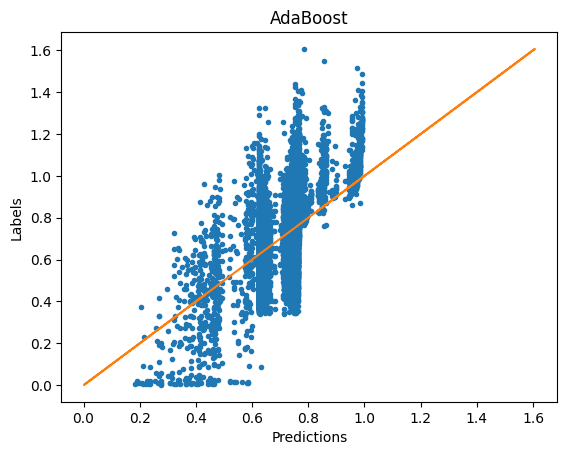

In [84]:
#Plot prediction vs label
plt.plot(ada_con_predictions, halos_labels, '.');
plt.plot(halos_labels, halos_labels);
plt.xlabel('Predictions');
plt.title('AdaBoost')
plt.ylabel('Labels');

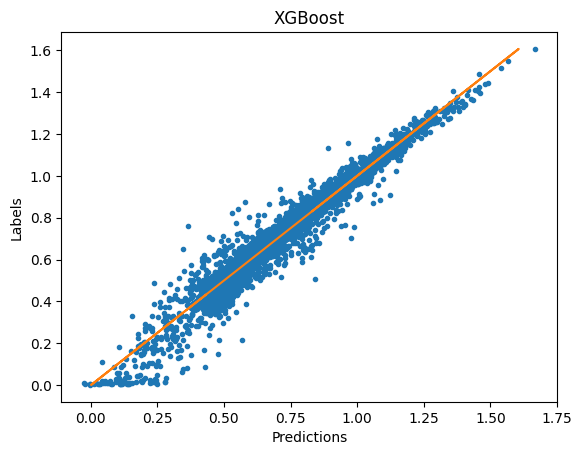

In [85]:
#Plot prediction vs label XGBoost
plt.plot(XGB_con_predictions, halos_labels, '.');
plt.plot(halos_labels, halos_labels);
plt.xlabel('Predictions');
plt.title('XGBoost')
plt.ylabel('Labels');

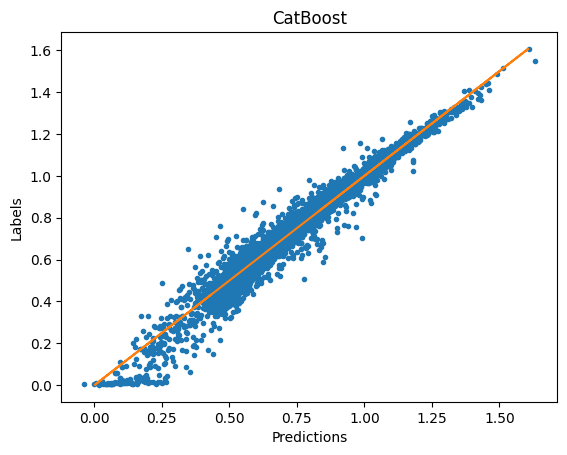

In [86]:
#Plot prediction vs label CatBoost
plt.plot(CAT_con_predictions, halos_labels, '.');
plt.plot(halos_labels, halos_labels);
plt.xlabel('Predictions');
plt.title('CatBoost')
plt.ylabel('Labels');

## **FINAL EVALUATION ON THE TEST SET**

In [87]:
#Evaluate the system in the test set
final_model_ada = grid_search_ada.best_estimator_

X_test = strat_test_set.drop('Concentration', axis=1)
y_test = strat_test_set['Concentration'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions_ada = final_model_ada.predict(X_test_prepared)

final_mse_ada = mean_squared_error(y_test, final_predictions_ada)
final_rmse_ada = np.sqrt(final_mse_ada)
print('Test Set RMSE for AdaBoost: ', final_rmse_ada)

Test Set RMSE for AdaBoost:  0.17894638608746513


In [88]:
#Evaluate the system in the test set
final_model_xgb = grid_search_xgb.best_estimator_

X_test = strat_test_set.drop('Concentration', axis=1)
y_test = strat_test_set['Concentration'].copy()

X_test_prepared_xgb = full_pipeline.transform(X_test)

final_predictions_xgb = final_model_xgb.predict(X_test_prepared_xgb)

final_mse_xgb = mean_squared_error(y_test, final_predictions_xgb)
final_rmse_xgb = np.sqrt(final_mse_xgb)
print('Test Set RMSE for XGBoost: ',final_rmse_xgb)

Test Set RMSE for XGBoost:  0.06405022363655993


In [89]:
#Evaluate the system in the test set
final_model_cat = grid_search_cat.best_estimator_

X_test = strat_test_set.drop('Concentration', axis=1)
y_test = strat_test_set['Concentration'].copy()

X_test_prepared_cat = full_pipeline.transform(X_test)

final_predictions_cat = final_model_cat.predict(X_test_prepared_cat)

final_mse_cat = mean_squared_error(y_test, final_predictions_cat)
final_rmse_cat = np.sqrt(final_mse_cat)
print('Test Set RMSE for CatBoost: ',final_rmse_cat)

Test Set RMSE for CatBoost:  0.06434714312382887


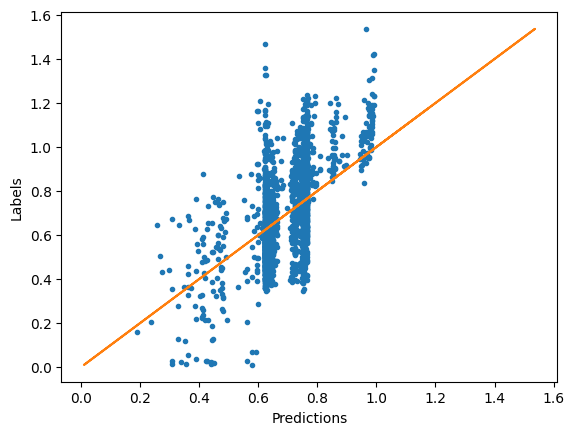

In [90]:
#Plot prediction vs label
plt.plot(final_predictions_ada, y_test, '.');
plt.plot(y_test, y_test);
plt.xlabel('Predictions');
plt.ylabel('Labels');

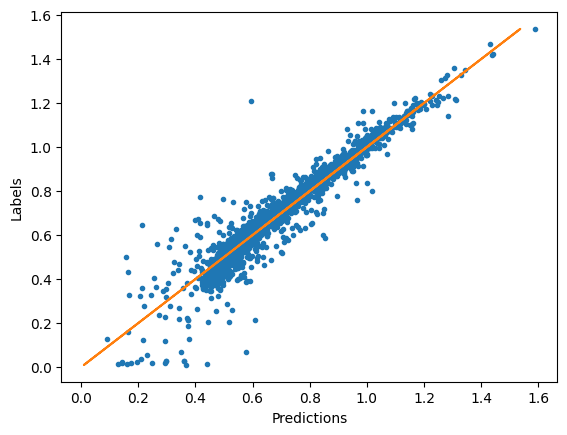

In [91]:
#Plot prediction vs label
plt.plot(final_predictions_xgb, y_test, '.');
plt.plot(y_test, y_test);
plt.xlabel('Predictions');
plt.ylabel('Labels');

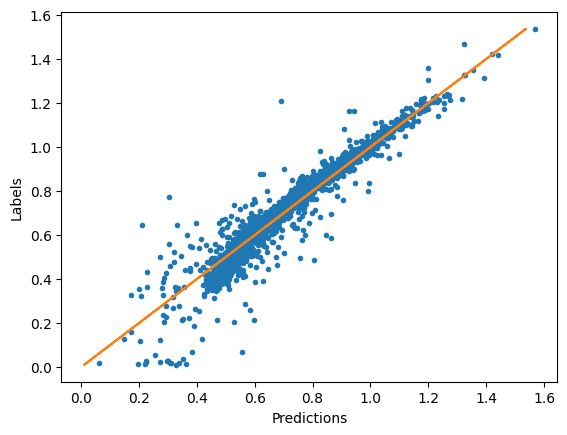

In [92]:
#Plot prediction vs label
plt.plot(final_predictions_cat, y_test, '.');
plt.plot(y_test, y_test);
plt.xlabel('Predictions');
plt.ylabel('Labels');
plt.savefig('/kaggle/working/plot.png')

<font size = "4">The test set plot for XGBoost and CatBoost shows a close alignment with the diagonal, with less scatter compared to AdaBoost. This consistency between the training and test set plots indicates that both of them are generalizing well to unseen data, maintaining a balance between bias and variance. 

## **-----------------The End-----------------**

<font size = "4"> **JOBLIB**

<font size = "3">To download the pipeline and the model for test.py

In [93]:
import joblib

# Save the preprocessing pipeline
#joblib.dump(full_pipeline, 'full_pipeline.pkl')
print("Preprocessing pipeline saved as 'full_pipeline.pkl'")

# Save the best XGBoost model (after hyperparameter tuning)
#joblib.dump(best_xgb, 'best_xgb_model.pkl')
print("Best XGBoost model saved as 'best_xgb_model.pkl'")


Preprocessing pipeline saved as 'full_pipeline.pkl'
Best XGBoost model saved as 'best_xgb_model.pkl'


In [94]:
import os

# Check if the files exist
print(os.path.isfile('full_pipeline.pkl'))
print(os.path.isfile('best_xgb_model.pkl'))


False
False


In [ ]:
import os

# List files in the working directory
print(os.listdir('/kaggle/working'))


In [ ]:
from IPython.display import FileLink

# Generate download links
FileLink('/kaggle/working/full_pipeline.pkl')
#FileLink('/kaggle/working/best_xgb_model.pkl')


In [ ]:
import pandas as pd
import numpy as np

# Load the data
#data = np.genfromtxt("/kaggle/input/dark-matter-2/hlist_0.13835.list.list", comments='#', skip_header=1000, max_rows=10000)

# Convert to DataFrame
#df = pd.DataFrame(data)

# Save the DataFrame to CSV
halos.to_csv('/kaggle/working/full_data.csv', index=False)

print("CSV file has been saved.")


In [ ]:
import xgboost
print(xgboost.__version__)

In [ ]:
import sklearn
print(sklearn.__version__)